Processing dataset...
Dataset Shape: (1800, 13)
Classes: ['Bearing' 'Flywheel' 'Healthy' 'LIV' 'LOV' 'NRV' 'Piston' 'Riderbelt']

[Step 1] Starting Automatic Feature Selection (RFECV)...
  > Optimal number of features: 11
  > Selected features: [np.str_('Mean_Freq'), np.str_('Spec_Std'), np.str_('Spec_Skew'), np.str_('Spec_Kurt'), np.str_('Spec_Entropy'), np.str_('Spec_Rolloff'), np.str_('Peak_Freq'), np.str_('Median_Freq'), np.str_('Crest_Factor'), np.str_('Max_High_Band'), np.str_('Total_Energy')]

[Step 2] Hyperparameter Tuning (GridSearchCV)...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
  > Best Parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Evaluating model...

--- Classification Report ---
              precision    recall  f1-score   support

     Bearing       0.84      0.93      0.88        45
    Flywheel       0.98      0.93      0.95        45
     Healthy       0.98      0.98      0.98        45
   

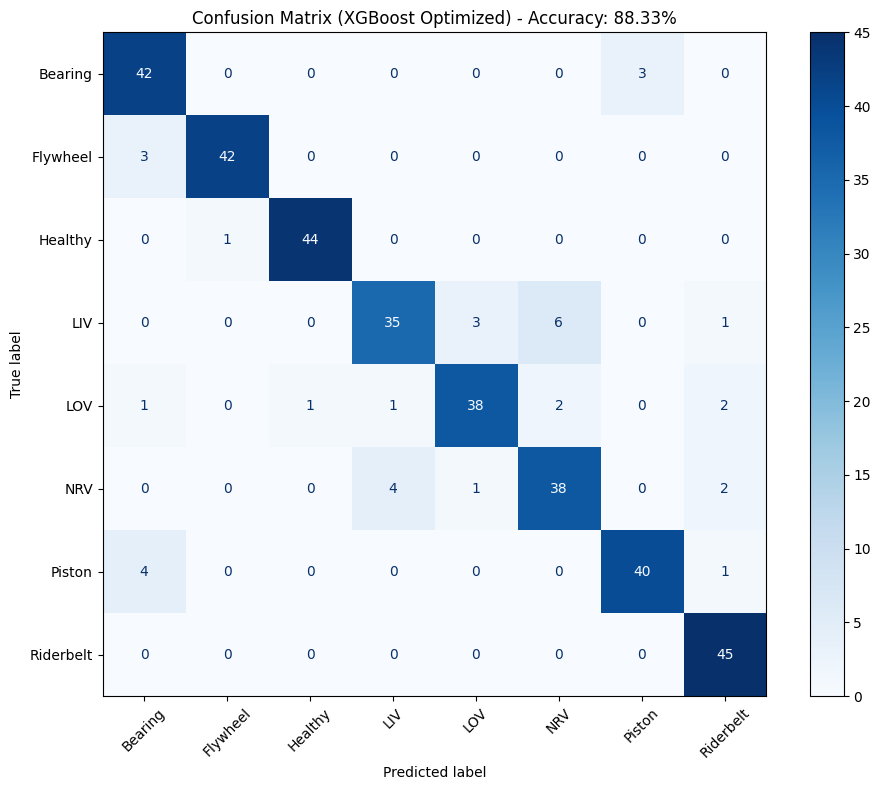

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend, iirnotch, sosfiltfilt, butter
from scipy.fft import fft, rfftfreq
from scipy.stats import skew, kurtosis, entropy, gmean
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATASET_DIR = os.path.join(os.getcwd(), "AirCompressor")
FS = 50000
EPS = 1e-12

# ==========================================
# 2. PREPROCESSING & FEATURE EXTRACTION LOGIC
# ==========================================
def preprocess_signal(signal):
    signal = detrend(signal)

    for f in [50, 300]:
        b, a = iirnotch(f, Q=30, fs=FS)
        sos = np.array([[b[0], b[1], b[2], a[0], a[1], a[2]]])
        signal = sosfiltfilt(sos, signal)

    sos = butter(6, 12000, fs=FS, btype='low', output='sos')
    signal = sosfiltfilt(sos, signal)
    return signal

def extract_features(signal):
    N = len(signal)
    yf = np.abs(fft(signal)[:N//2])
    xf = rfftfreq(N, 1/FS)[:N//2]

    P = yf**2
    P_sum = np.sum(P) + EPS
    prob_P = P / P_sum

    mean_freq = np.sum(xf * prob_P)
    std_freq = np.sqrt(np.sum(((xf - mean_freq)**2) * prob_P))
    spec_skew = np.sum(((xf - mean_freq)**3) * prob_P) / (std_freq**3 + EPS)
    spec_kurt = np.sum(((xf - mean_freq)**4) * prob_P) / (std_freq**4 + EPS)
    spec_entropy = entropy(prob_P)
    spec_flatness = gmean(P + EPS) / (np.mean(P) + EPS)

    cum_energy = np.cumsum(P)
    rolloff_idx = np.where(cum_energy >= 0.85 * P_sum)[0][0]
    spec_rolloff = xf[rolloff_idx]
    
    peak_freq = xf[np.argmax(P)]

    median_idx = np.where(cum_energy >= 0.50 * P_sum)[0][0]
    median_freq = xf[median_idx]
    
    rmsf = np.sqrt(np.sum((xf**2) * prob_P))
    crest_factor = np.max(P) / (np.mean(P) + EPS)

    high_band_idx = np.where(xf > 6000)
    max_high_band = np.max(P[high_band_idx]) if len(high_band_idx[0]) > 0 else 0
        
    total_energy = np.sum(P)

    feats = [
        mean_freq, std_freq, spec_skew, spec_kurt, spec_entropy,
        spec_flatness, spec_rolloff, peak_freq, median_freq, rmsf,
        crest_factor, max_high_band, total_energy
    ]
    
    names = [
        "Mean_Freq", "Spec_Std", "Spec_Skew", "Spec_Kurt", "Spec_Entropy",
        "Spec_Flatness", "Spec_Rolloff", "Peak_Freq", "Median_Freq", "RMSF",
        "Crest_Factor", "Max_High_Band", "Total_Energy"
    ]
    return feats, names

# ==========================================
# 3. DATA LOADING & DATASET CREATION
# ==========================================
if not os.path.exists(DATASET_DIR):
    raise FileNotFoundError(f"Directory '{DATASET_DIR}' not found.")

X_data, y_data = [], []
feat_names = []

print("Processing dataset...")

subfolders = [f.path for f in os.scandir(DATASET_DIR) if f.is_dir()]

for subfolder in subfolders:
    label = os.path.basename(subfolder)
    files = [f for f in os.listdir(subfolder) if f.endswith(".dat")]
    
    for file in files:
        try:
            filepath = os.path.join(subfolder, file)
            # Load
            raw_signal = np.loadtxt(filepath)
            # Preprocess
            clean_signal = preprocess_signal(raw_signal)
            # Feature Extraction
            feats, names = extract_features(clean_signal)
            
            X_data.append(feats)
            y_data.append(label)
            if not feat_names: feat_names = names
            
        except Exception as e:
            print(f"Skipping {file}: {e}")
            continue

X = np.array(X_data)
y = np.array(y_data)

le = LabelEncoder()
y_enc = le.fit_transform(y)

print(f"Dataset Shape: {X.shape}")
print(f"Classes: {le.classes_}")

# ==========================================
# 4. DATA SPLITTING & SCALING
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# ==========================================
# 5. FEATURE SELECTION (RFECV)
# ==========================================
print("\n[Step 1] Starting Automatic Feature Selection (RFECV)...")

xgb_selector = XGBClassifier(
    n_estimators=100, 
    eval_metric='mlogloss', 
    random_state=42,
    n_jobs=-1
)

rfecv = RFECV(
    estimator=xgb_selector, 
    step=1, 
    cv=StratifiedKFold(5), 
    scoring='accuracy',
    n_jobs=-1
)
rfecv.fit(X_train_s, y_train)

print(f"  > Optimal number of features: {rfecv.n_features_}")
selected_features = np.array(feat_names)[rfecv.support_]
print(f"  > Selected features: {list(selected_features)}")

X_train_sel = rfecv.transform(X_train_s)
X_test_sel = rfecv.transform(X_test_s)

# ==========================================
# 6. MODEL TRAINING (HYPERPARAMETER TUNING)
# ==========================================
print("\n[Step 2] Hyperparameter Tuning (GridSearchCV)...")

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(eval_metric='mlogloss', random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_sel, y_train)

best_model = grid_search.best_estimator_
print(f"  > Best Parameters: {grid_search.best_params_}")

# ==========================================
# 7. EVALUATION
# ==========================================
print("Evaluating model...")
y_pred = best_model.predict(X_test_sel)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8)) 
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
plt.title(f"Confusion Matrix (XGBoost Optimized) - Accuracy: {final_acc:.2%}")
plt.tight_layout()
plt.show()